<a href="https://colab.research.google.com/github/Madhubi-web/Omi_project1/blob/main/Brain_Tumor_Detection_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Upload and Setup Kaggle API**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2.Import Libraries**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm.notebook import tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

In [ ]:
BASE_PATH = '/content/drive/MyDrive/Brain Tumor Detection'  # Modify this path as needed
YES_PATH = os.path.join(BASE_PATH, 'yes')
NO_PATH = os.path.join(BASE_PATH, 'no')

In [ ]:
X = []
y = []

# Load 'yes' images
print("Loading images from 'yes' folder...")
for i in tqdm(os.listdir(YES_PATH)):
    img_path = os.path.join(YES_PATH, i)
    img = cv2.imread(img_path)
    if img is not None:  # Add error checking
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append('Y')

# Load 'no' images
print("Loading images from 'no' folder...")
for i in tqdm(os.listdir(NO_PATH)):
    img_path = os.path.join(NO_PATH, i)
    img = cv2.imread(img_path)
    if img is not None:  # Add error checking
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append('N')


Loading images from 'yes' folder...


  0%|          | 0/155 [00:00<?, ?it/s]

Loading images from 'no' folder...


  0%|          | 0/98 [00:00<?, ?it/s]

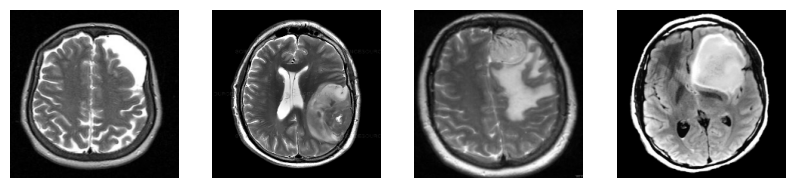

In [ ]:
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("Shape of an image in X_train: ", X_train[0].shape)
print("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [ ]:
# Encode labels
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)

In [ ]:
# Convert to numpy arrays
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (169, 224, 224, 3)
X_test Shape:  (84, 224, 224, 3)
y_train Shape:  (169, 2)
y_test Shape:  (84, 2)


In [ ]:
# VGG16 Model setup
from keras.applications import vgg16

img_rows, img_cols = 224, 224

vgg = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(img_rows, img_cols, 3))

# Freeze layers
for layer in vgg.layers:
    layer.trainable = False

# Print layers
for (i, layer) in enumerate(vgg.layers):
    print(str(i) + " " + layer.__class__.__name__, layer.trainable)

def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be
    placed ontop of the bottom layers"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model


0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [ ]:
# Create and compile model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
num_classes = 2
FC_Head = lw(vgg, num_classes)
model = tf.keras.Model(inputs=vgg.input, outputs=FC_Head)
print(model.summary())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,3

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
# Train model
history = model.fit(X_train, y_train,
                   epochs=5,
                   validation_data=(X_test, y_test),
                   verbose=1,
                   initial_epoch=0)

Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 142s 24s/step - accuracy: 0.5603 - loss: 4.0960 - val_accuracy: 0.4048 - val_loss: 4.4501
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 142s 25s/step - accuracy: 0.5115 - loss: 2.7961 - val_accuracy: 0.7381 - val_loss: 0.7664
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 180s 32s/step - accuracy: 0.8298 - loss: 0.3807 - val_accuracy: 0.8929 - val_loss: 0.3367
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 164s 25s/step - accuracy: 0.9427 - loss: 0.1772 - val_accuracy: 0.8690 - val_loss: 0.3295
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 140s 25s/step - accuracy: 0.9470 - loss: 0.1348 - val_accuracy: 0.8929 - val_loss: 0.3690


3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 14s/step

Evaluation Metrics:
Precision: 0.8621
Recall: 0.9804
F1 Score: 0.9174


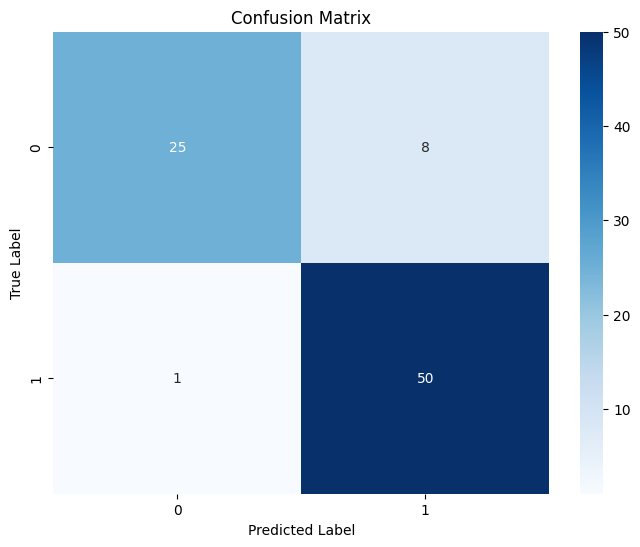


Classification Report:
              precision    recall  f1-score   support

    No Tumor       0.96      0.76      0.85        33
       Tumor       0.86      0.98      0.92        51

    accuracy                           0.89        84
   macro avg       0.91      0.87      0.88        84
weighted avg       0.90      0.89      0.89        84



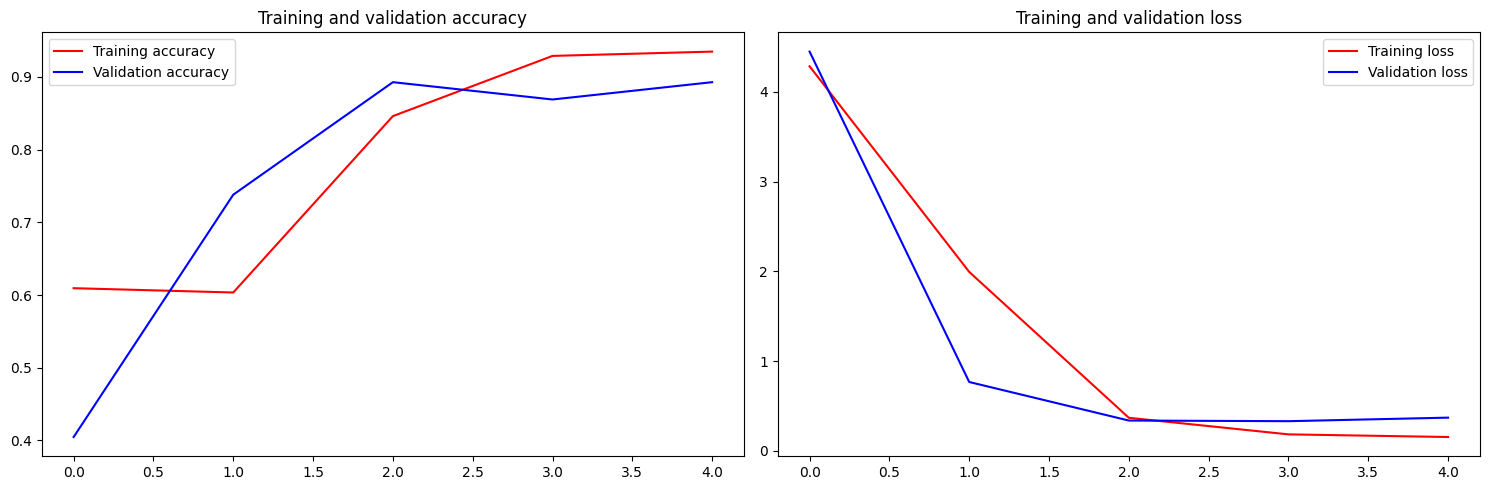


Detailed Metrics per Class:
Sensitivity (True Positive Rate): 0.9804
Specificity (True Negative Rate): 0.7576

Confusion Matrix Components:
True Positives: 50
True Negatives: 25
False Positives: 8
False Negatives: 1


In [ ]:
# Evaluate the model
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

global model # Make sure the model variable is accessible in this cell

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate metrics
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes)

# Print metrics
print('\nEvaluation Metrics:')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Create confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print detailed classification report
print('\nClassification Report:')
print(classification_report(y_test_classes, y_pred_classes,
                          target_names=['No Tumor', 'Tumor']))

# Your existing accuracy and loss plots
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Create subplot for all metrics
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)

plt.tight_layout()
plt.show()

# Calculate and print additional metrics per class
print('\nDetailed Metrics per Class:')
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

print(f'Sensitivity (True Positive Rate): {sensitivity:.4f}')
print(f'Specificity (True Negative Rate): {specificity:.4f}')
print('\nConfusion Matrix Components:')
print(f'True Positives: {TP}')
print(f'True Negatives: {TN}')
print(f'False Positives: {FP}')
print(f'False Negatives: {FN}')

# Save the results to a text file
with open('model_evaluation_results.txt', 'w') as f:
    f.write('Brain Tumor Detection Model Evaluation Results\n')
    f.write('============================================\n\n')
    f.write(f'Precision: {precision:.4f}\n')
    f.write(f'Recall: {recall:.4f}\n')
    f.write(f'F1 Score: {f1:.4f}\n')
    f.write(f'Sensitivity: {sensitivity:.4f}\n')
    f.write(f'Specificity: {specificity:.4f}\n\n')
    f.write('Confusion Matrix Components:\n')
    f.write(f'True Positives: {TP}\n')
    f.write(f'True Negatives: {TN}\n')
    f.write(f'False Positives: {FP}\n')
    f.write(f'False Negatives: {FN}\n\n')
    f.write('Classification Report:\n')
    f.write(classification_report(y_test_classes, y_pred_classes,
                                target_names=['No Tumor', 'Tumor']))